# Tutorial 4: Unstructured Pruning on Bert

Pruning is a technique used to reduce the size and complexity of neural networks by removing unnecessary parameters (weights and connections) or structural components (neurons, filters, or layers). The goal is to create a smaller, more efficient model that maintains most of the original model's performance. The following benefits can be seen from pruning neural networks:

- **Reduce model size**: Deep neural networks often have millions of parameters, leading to large storage requirements.

- **Decrease inference time**: Fewer parameters mean fewer computations, resulting in faster predictions.

- **Improve generalization**: Removing unnecessary connections can help prevent overfitting.

- **Energy efficiency**: Smaller models require less energy to run, which is crucial for edge devices and mobile applications.

Structured pruning removes entire structures (e.g., channels, filters, or layers) from the network, while unstructured pruning removes individual weights or connections from the network, regardless of their location. In this tutorial, we'll build on top of Tutorial 3 by taking the quantized Bert model and running Mase's unstructured pruning pass. After pruning, we'll run further fine tuning iterations to retain sequence classification accuracy in the pruned model.

In [ ]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [ ]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

If you have previously ran the tutorial on Quantization-Aware Training (QAT), run the following cell to import the fine tuned checkpoint.

In [9]:
from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/best_model_3")

## Unstructured Pruning

Before running pruning, let's evaluate the model accuracy on the IMDb dataset. If you're coming from Tutorial, this would be the same as the accuracy after Quantization Aware Training (QAT). If you've just initialized the model, this will likely be a random guess (i.e. around 50%), in which case pruning wouldn't have a significant effect on the accuracy.

In [ ]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.7662


To run the pruning pass, we pass the following pruning configuration dictionary, which defines the following parameters.

- **Sparsity**: a value between 0 and 1, expressing the proportion of elements in the model that should be pruned (i.e. set to 0).

- **Method**: several pruning methods are supported, including ``Random`` and ``L1-Norm``.

- **Scope**: defines whether to consider each weight/activation tensor individually (``local``) or all tensors in the model (``global``) when obtaining statistics for pruning (e.g. absolute value threshold for pruning)

We'll start by running random pruning with local scope, at a fixed sparsity. This may be suboptimal, but in future tutorials we'll see how to find optimal pruning and quantization configurations for a given model on a specified dataset.

In [10]:
import chop.passes as passes
pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Let's evaluate the effect of pruning on accuracy. It's likely to observe drops of around 10% or more.

In [ ]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
    num_train_epochs=5,
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

To overcome the drop in accuracy, we'll run a few finetuning epochs. This allows the model to adapt to the new pruning mask.

In [ ]:
trainer.train()

Let's evaluate the model accuracy after finetuning. We should see that the accuracy is reverted back to the original level.

In [ ]:
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

In [ ]:
pruning_sweep = []
sparsity = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for val in sparsity:
  curr_results = {
    "Sparsity": val,
    "Method": "l1-norm"
  }
  mg = MaseGraph.from_checkpoint(f"{Path.home()}/best_model_3")
  pruning_config = {
    "weight": {
        "sparsity": val,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": val,
        "method": "l1-norm",
        "scope": "local",
    },
  }

  mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)
  trainer = get_trainer(
      model=mg.model,
      tokenized_dataset=dataset,
      tokenizer=tokenizer,
      evaluate_metric="accuracy",
      num_train_epochs=5,
      
  )

  # Evaluate accuracy
  sparsity_results = trainer.evaluate()
  print(f"Post-pruning accuracy: {sparsity_results['eval_accuracy']}")
  curr_results["Post-Pruning Accuracy"] = sparsity_results['eval_accuracy']
  
  
  trainer.train()
  finetune_results = trainer.evaluate()
  print(f"Finetune accuracy: {finetune_results['eval_accuracy']}")
  curr_results["Finetuned Accuracy"] = finetune_results['eval_accuracy']

  pruning_sweep.append(curr_results)

In [ ]:
from pandas import DataFrame

df = DataFrame(pruning_sweep)
print(df)
df.to_csv("labs_media/l1-norm-results.csv", index=False)

In [ ]:
import torch
from chop.tools import get_tokenized_dataset, get_trainer

pruning_sweep = []
sparsity = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for val in sparsity:
  curr_results = {
    "Sparsity": val,
    "Method": "random"
  }
  mg = MaseGraph.from_checkpoint(f"{Path.home()}/best_model_3")
  pruning_config = {
    "weight": {
        "sparsity": val,
        "method": "random",
        "scope": "local",
    },
    "activation": {
        "sparsity": val,
        "method": "random",
        "scope": "local",
    },
  }

  mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)
  if torch.cuda.is_available():
    mg.model.to('cuda')
    print("On GPU")

  trainer = get_trainer(
      model=mg.model,
      tokenized_dataset=dataset,
      tokenizer=tokenizer,
      evaluate_metric="accuracy",
      num_train_epochs=5,
  )

  trainer.args.per_device_eval_batch_size=256
  trainer.args.per_device_train_batch_size=256
  trainer.args.dataloader_num_workers=8
  trainer.args.dataloader_pin_memory=True

  # Evaluate accuracy
  sparsity_results = trainer.evaluate()
  print(f"Post-pruning accuracy: {sparsity_results['eval_accuracy']}")
  curr_results["Post-Pruning Accuracy"] = sparsity_results['eval_accuracy']
  
  
  trainer.train()
  finetune_results = trainer.evaluate()
  print(f"Finetune accuracy: {finetune_results['eval_accuracy']}")
  curr_results["Finetuned Accuracy"] = finetune_results['eval_accuracy']

  pruning_sweep.append(curr_results)

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


On GPU


/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
print("It is free")

It is free


In [15]:
print(pruning_sweep)

[{'Sparsity': 0.1, 'Method': 'random', 'Post-Pruning Accuracy': 0.7628, 'Finetuned Accuracy': 0.84024}, {'Sparsity': 0.2, 'Method': 'random', 'Post-Pruning Accuracy': 0.64764, 'Finetuned Accuracy': 0.82388}, {'Sparsity': 0.3, 'Method': 'random', 'Post-Pruning Accuracy': 0.56064, 'Finetuned Accuracy': 0.80608}, {'Sparsity': 0.4, 'Method': 'random', 'Post-Pruning Accuracy': 0.51224, 'Finetuned Accuracy': 0.78688}, {'Sparsity': 0.5, 'Method': 'random', 'Post-Pruning Accuracy': 0.50128, 'Finetuned Accuracy': 0.74184}, {'Sparsity': 0.6, 'Method': 'random', 'Post-Pruning Accuracy': 0.5016, 'Finetuned Accuracy': 0.51832}, {'Sparsity': 0.7, 'Method': 'random', 'Post-Pruning Accuracy': 0.49976, 'Finetuned Accuracy': 0.50412}, {'Sparsity': 0.8, 'Method': 'random', 'Post-Pruning Accuracy': 0.50008, 'Finetuned Accuracy': 0.50012}, {'Sparsity': 0.9, 'Method': 'random', 'Post-Pruning Accuracy': 0.49956, 'Finetuned Accuracy': 0.5018}]


In [32]:
from pandas import DataFrame
import pandas as pd

random_df = DataFrame(pruning_sweep)
print(random_df)
random_df.to_csv("labs_media/tut-4-random-results.csv", index=False)

   Sparsity  Method  Post-Pruning Accuracy  Finetuned Accuracy
0       0.1  random                0.76280             0.84024
1       0.2  random                0.64764             0.82388
2       0.3  random                0.56064             0.80608
3       0.4  random                0.51224             0.78688
4       0.5  random                0.50128             0.74184
5       0.6  random                0.50160             0.51832
6       0.7  random                0.49976             0.50412
7       0.8  random                0.50008             0.50012
8       0.9  random                0.49956             0.50180


In [33]:
l1_norm_df = pd.read_csv("labs_media/l1-norm-results.csv")

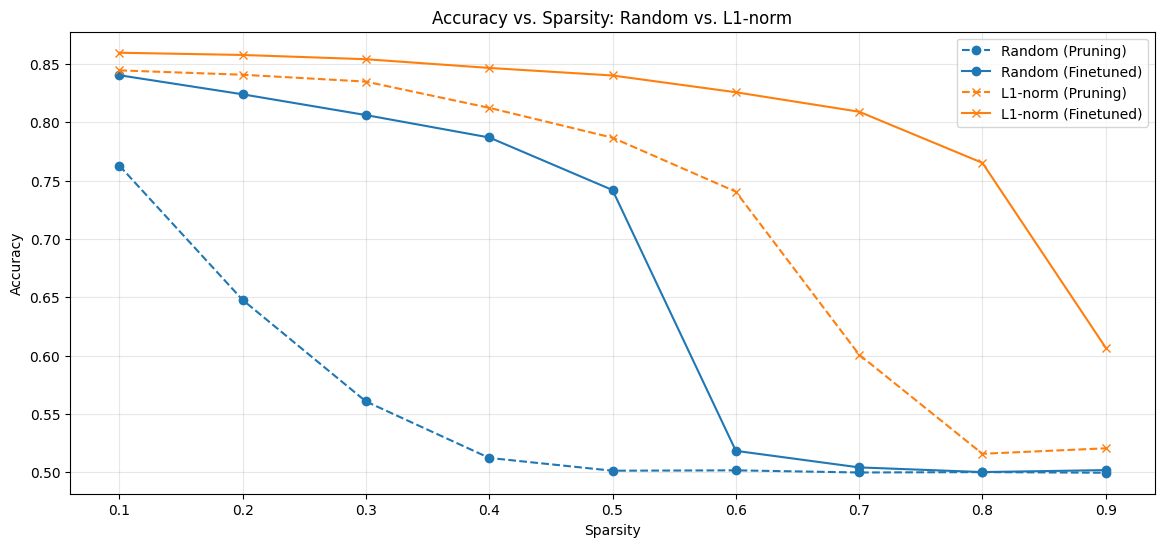

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Random: Blue
plt.plot(random_df["Sparsity"], random_df["Post-Pruning Accuracy"], 
         label="Random (Pruning)", linestyle="--", marker="o", color="tab:blue")
plt.plot(random_df["Sparsity"], random_df["Finetuned Accuracy"], 
         label="Random (Finetuned)", linestyle="-", marker="o", color="tab:blue")

# L1-norm: Orange
plt.plot(l1_norm_df["Sparsity"], l1_norm_df["Post-Pruning Accuracy"], 
         label="L1-norm (Pruning)", linestyle="--", marker="x", color="tab:orange")
plt.plot(l1_norm_df["Sparsity"], l1_norm_df["Finetuned Accuracy"], 
         label="L1-norm (Finetuned)", linestyle="-", marker="x", color="tab:orange")

# 3. Aesthetics
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Sparsity: Random vs. L1-norm")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(random_df["Sparsity"])
plt.show()